In [10]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils


class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        print('update')
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        
        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()
        print('state.shape',states.shape)
        print('actions.shape',actions.shape)
        print('rewards.shape',rewards.shape)
        print('next_states.shape',next_states.shape)
        print('dones.shape',dones.shape)
        print('td_target.shape',td_target.shape)
        print('td_delta.shape',td_delta.shape)
        print('advantage.shape',advantage.shape)
        print('old_log_probs.shape',old_log_probs.shape)
        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps,
                                1 + self.eps) * advantage  # 截断
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [11]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

# Iteration 0: 100%|██████████| 50/50 [00:10<00:00,  4.81it/s, episode=50,
# return=183.200]
# Iteration 1: 100%|██████████| 50/50 [00:22<00:00,  2.24it/s, episode=100,
# return=191.400]
# Iteration 2: 100%|██████████| 50/50 [00:22<00:00,  2.24it/s, episode=150,
# return=199.900]
# Iteration 3: 100%|██████████| 50/50 [00:21<00:00,  2.33it/s, episode=200,
# return=200.000]
# Iteration 4: 100%|██████████| 50/50 [00:21<00:00,  2.29it/s, episode=250,
# return=200.000]
# Iteration 5: 100%|██████████| 50/50 [00:22<00:00,  2.22it/s, episode=300,
# return=200.000]
# Iteration 6: 100%|██████████| 50/50 [00:23<00:00,  2.14it/s, episode=350,
# return=200.000]
# Iteration 7: 100%|██████████| 50/50 [00:23<00:00,  2.16it/s, episode=400,
# return=200.000]
# Iteration 8: 100%|██████████| 50/50 [00:22<00:00,  2.23it/s, episode=450,
# return=200.000]
# Iteration 9: 100%|██████████| 50/50 [00:22<00:00,  2.25it/s, episode=500,
# return=200.000]

/usr/local/miniconda3/envs/HandsonRL/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/miniconda3/envs/HandsonRL/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 0:   6%|▌         | 3/50 [00:00<00:02, 21.20it/s]

update
state.shape torch.Size([34, 4])
actions.shape torch.Size([34, 1])
rewards.shape torch.Size([34, 1])
next_states.shape torch.Size([34, 4])
dones.shape torch.Size([34, 1])
td_target.shape torch.Size([34, 1])
td_delta.shape torch.Size([34, 1])
advantage.shape torch.Size([34, 1])
old_log_probs.shape torch.Size([34, 1])
update
state.shape torch.Size([22, 4])
actions.shape torch.Size([22, 1])
rewards.shape torch.Size([22, 1])
next_states.shape torch.Size([22, 4])
dones.shape torch.Size([22, 1])
td_target.shape torch.Size([22, 1])
td_delta.shape torch.Size([22, 1])
advantage.shape torch.Size([22, 1])
old_log_probs.shape torch.Size([22, 1])
update
state.shape torch.Size([38, 4])
actions.shape torch.Size([38, 1])
rewards.shape torch.Size([38, 1])
next_states.shape torch.Size([38, 4])
dones.shape torch.Size([38, 1])
td_target.shape torch.Size([38, 1])
td_delta.shape torch.Size([38, 1])
advantage.shape torch.Size([38, 1])
old_log_probs.shape torch.Size([38, 1])
update
state.shape torch.Siz

Iteration 0:  18%|█▊        | 9/50 [00:00<00:01, 24.57it/s, episode=10, return=21.900]

update
state.shape torch.Size([11, 4])
actions.shape torch.Size([11, 1])
rewards.shape torch.Size([11, 1])
next_states.shape torch.Size([11, 4])
dones.shape torch.Size([11, 1])
td_target.shape torch.Size([11, 1])
td_delta.shape torch.Size([11, 1])
advantage.shape torch.Size([11, 1])
old_log_probs.shape torch.Size([11, 1])
update
state.shape torch.Size([28, 4])
actions.shape torch.Size([28, 1])
rewards.shape torch.Size([28, 1])
next_states.shape torch.Size([28, 4])
dones.shape torch.Size([28, 1])
td_target.shape torch.Size([28, 1])
td_delta.shape torch.Size([28, 1])
advantage.shape torch.Size([28, 1])
old_log_probs.shape torch.Size([28, 1])
update
state.shape torch.Size([12, 4])
actions.shape torch.Size([12, 1])
rewards.shape torch.Size([12, 1])
next_states.shape torch.Size([12, 4])
dones.shape torch.Size([12, 1])
td_target.shape torch.Size([12, 1])
td_delta.shape torch.Size([12, 1])
advantage.shape torch.Size([12, 1])
old_log_probs.shape torch.Size([12, 1])
update
state.shape torch.Siz

Iteration 0:  30%|███       | 15/50 [00:00<00:01, 23.47it/s, episode=10, return=21.900]

update
state.shape torch.Size([16, 4])
actions.shape torch.Size([16, 1])
rewards.shape torch.Size([16, 1])
next_states.shape torch.Size([16, 4])
dones.shape torch.Size([16, 1])
td_target.shape torch.Size([16, 1])
td_delta.shape torch.Size([16, 1])
advantage.shape torch.Size([16, 1])
old_log_probs.shape torch.Size([16, 1])
update
state.shape torch.Size([18, 4])
actions.shape torch.Size([18, 1])
rewards.shape torch.Size([18, 1])
next_states.shape torch.Size([18, 4])
dones.shape torch.Size([18, 1])
td_target.shape torch.Size([18, 1])
td_delta.shape torch.Size([18, 1])
advantage.shape torch.Size([18, 1])
old_log_probs.shape torch.Size([18, 1])
update
state.shape torch.Size([11, 4])
actions.shape torch.Size([11, 1])
rewards.shape torch.Size([11, 1])
next_states.shape torch.Size([11, 4])
dones.shape torch.Size([11, 1])
td_target.shape torch.Size([11, 1])
td_delta.shape torch.Size([11, 1])
advantage.shape torch.Size([11, 1])
old_log_probs.shape torch.Size([11, 1])
update
state.shape torch.Siz

Iteration 0:  36%|███▌      | 18/50 [00:00<00:01, 20.14it/s, episode=10, return=21.900]

update
state.shape torch.Size([45, 4])
actions.shape torch.Size([45, 1])
rewards.shape torch.Size([45, 1])
next_states.shape torch.Size([45, 4])
dones.shape torch.Size([45, 1])
td_target.shape torch.Size([45, 1])
td_delta.shape torch.Size([45, 1])
advantage.shape torch.Size([45, 1])
old_log_probs.shape torch.Size([45, 1])
update
state.shape torch.Size([119, 4])
actions.shape torch.Size([119, 1])
rewards.shape torch.Size([119, 1])
next_states.shape torch.Size([119, 4])
dones.shape torch.Size([119, 1])
td_target.shape torch.Size([119, 1])
td_delta.shape torch.Size([119, 1])
advantage.shape torch.Size([119, 1])
old_log_probs.shape torch.Size([119, 1])
update
state.shape torch.Size([95, 4])
actions.shape torch.Size([95, 1])
rewards.shape torch.Size([95, 1])
next_states.shape torch.Size([95, 4])
dones.shape torch.Size([95, 1])
td_target.shape torch.Size([95, 1])
td_delta.shape torch.Size([95, 1])
advantage.shape torch.Size([95, 1])
old_log_probs.shape torch.Size([95, 1])


Iteration 0:  42%|████▏     | 21/50 [00:01<00:01, 17.67it/s, episode=20, return=47.800]

update
state.shape torch.Size([39, 4])
actions.shape torch.Size([39, 1])
rewards.shape torch.Size([39, 1])
next_states.shape torch.Size([39, 4])
dones.shape torch.Size([39, 1])
td_target.shape torch.Size([39, 1])
td_delta.shape torch.Size([39, 1])
advantage.shape torch.Size([39, 1])
old_log_probs.shape torch.Size([39, 1])
update
state.shape torch.Size([100, 4])
actions.shape torch.Size([100, 1])
rewards.shape torch.Size([100, 1])
next_states.shape torch.Size([100, 4])
dones.shape torch.Size([100, 1])
td_target.shape torch.Size([100, 1])
td_delta.shape torch.Size([100, 1])
advantage.shape torch.Size([100, 1])
old_log_probs.shape torch.Size([100, 1])
update
state.shape torch.Size([103, 4])
actions.shape torch.Size([103, 1])
rewards.shape torch.Size([103, 1])
next_states.shape torch.Size([103, 4])
dones.shape torch.Size([103, 1])
td_target.shape torch.Size([103, 1])
td_delta.shape torch.Size([103, 1])
advantage.shape torch.Size([103, 1])
old_log_probs.shape torch.Size([103, 1])


Iteration 0:  46%|████▌     | 23/50 [00:01<00:01, 16.52it/s, episode=20, return=47.800]

update
state.shape torch.Size([69, 4])
actions.shape torch.Size([69, 1])
rewards.shape torch.Size([69, 1])
next_states.shape torch.Size([69, 4])
dones.shape torch.Size([69, 1])
td_target.shape torch.Size([69, 1])
td_delta.shape torch.Size([69, 1])
advantage.shape torch.Size([69, 1])
old_log_probs.shape torch.Size([69, 1])
update
state.shape torch.Size([26, 4])
actions.shape torch.Size([26, 1])
rewards.shape torch.Size([26, 1])
next_states.shape torch.Size([26, 4])
dones.shape torch.Size([26, 1])
td_target.shape torch.Size([26, 1])
td_delta.shape torch.Size([26, 1])
advantage.shape torch.Size([26, 1])
old_log_probs.shape torch.Size([26, 1])
update
state.shape torch.Size([51, 4])
actions.shape torch.Size([51, 1])
rewards.shape torch.Size([51, 1])
next_states.shape torch.Size([51, 4])
dones.shape torch.Size([51, 1])
td_target.shape torch.Size([51, 1])
td_delta.shape torch.Size([51, 1])
advantage.shape torch.Size([51, 1])
old_log_probs.shape torch.Size([51, 1])
update
state.shape torch.Siz

Iteration 0:  56%|█████▌    | 28/50 [00:01<00:01, 12.79it/s, episode=20, return=47.800]

update
state.shape torch.Size([151, 4])
actions.shape torch.Size([151, 1])
rewards.shape torch.Size([151, 1])
next_states.shape torch.Size([151, 4])
dones.shape torch.Size([151, 1])
td_target.shape torch.Size([151, 1])
td_delta.shape torch.Size([151, 1])
advantage.shape torch.Size([151, 1])
old_log_probs.shape torch.Size([151, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 0:  60%|██████    | 30/50 [00:01<00:01, 12.36it/s, episode=30, return=106.000]

update
state.shape torch.Size([165, 4])
actions.shape torch.Size([165, 1])
rewards.shape torch.Size([165, 1])
next_states.shape torch.Size([165, 4])
dones.shape torch.Size([165, 1])
td_target.shape torch.Size([165, 1])
td_delta.shape torch.Size([165, 1])
advantage.shape torch.Size([165, 1])
old_log_probs.shape torch.Size([165, 1])
update
state.shape torch.Size([55, 4])
actions.shape torch.Size([55, 1])
rewards.shape torch.Size([55, 1])
next_states.shape torch.Size([55, 4])
dones.shape torch.Size([55, 1])
td_target.shape torch.Size([55, 1])
td_delta.shape torch.Size([55, 1])
advantage.shape torch.Size([55, 1])
old_log_probs.shape torch.Size([55, 1])
update
state.shape torch.Size([146, 4])
actions.shape torch.Size([146, 1])
rewards.shape torch.Size([146, 1])
next_states.shape torch.Size([146, 4])
dones.shape torch.Size([146, 1])
td_target.shape torch.Size([146, 1])
td_delta.shape torch.Size([146, 1])
advantage.shape torch.Size([146, 1])
old_log_probs.shape torch.Size([146, 1])


Iteration 0:  68%|██████▊   | 34/50 [00:02<00:01, 12.06it/s, episode=30, return=106.000]

update
state.shape torch.Size([118, 4])
actions.shape torch.Size([118, 1])
rewards.shape torch.Size([118, 1])
next_states.shape torch.Size([118, 4])
dones.shape torch.Size([118, 1])
td_target.shape torch.Size([118, 1])
td_delta.shape torch.Size([118, 1])
advantage.shape torch.Size([118, 1])
old_log_probs.shape torch.Size([118, 1])
update
state.shape torch.Size([138, 4])
actions.shape torch.Size([138, 1])
rewards.shape torch.Size([138, 1])
next_states.shape torch.Size([138, 4])
dones.shape torch.Size([138, 1])
td_target.shape torch.Size([138, 1])
td_delta.shape torch.Size([138, 1])
advantage.shape torch.Size([138, 1])
old_log_probs.shape torch.Size([138, 1])
update
state.shape torch.Size([26, 4])
actions.shape torch.Size([26, 1])
rewards.shape torch.Size([26, 1])
next_states.shape torch.Size([26, 4])
dones.shape torch.Size([26, 1])
td_target.shape torch.Size([26, 1])
td_delta.shape torch.Size([26, 1])
advantage.shape torch.Size([26, 1])
old_log_probs.shape torch.Size([26, 1])


Iteration 0:  72%|███████▏  | 36/50 [00:02<00:01, 12.76it/s, episode=30, return=106.000]

update
state.shape torch.Size([115, 4])
actions.shape torch.Size([115, 1])
rewards.shape torch.Size([115, 1])
next_states.shape torch.Size([115, 4])
dones.shape torch.Size([115, 1])
td_target.shape torch.Size([115, 1])
td_delta.shape torch.Size([115, 1])
advantage.shape torch.Size([115, 1])
old_log_probs.shape torch.Size([115, 1])
update
state.shape torch.Size([26, 4])
actions.shape torch.Size([26, 1])
rewards.shape torch.Size([26, 1])
next_states.shape torch.Size([26, 4])
dones.shape torch.Size([26, 1])
td_target.shape torch.Size([26, 1])
td_delta.shape torch.Size([26, 1])
advantage.shape torch.Size([26, 1])
old_log_probs.shape torch.Size([26, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 0:  76%|███████▌  | 38/50 [00:02<00:01, 10.37it/s, episode=30, return=106.000]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 0:  80%|████████  | 40/50 [00:02<00:00, 10.04it/s, episode=40, return=125.500]

update
state.shape torch.Size([86, 4])
actions.shape torch.Size([86, 1])
rewards.shape torch.Size([86, 1])
next_states.shape torch.Size([86, 4])
dones.shape torch.Size([86, 1])
td_target.shape torch.Size([86, 1])
td_delta.shape torch.Size([86, 1])
advantage.shape torch.Size([86, 1])
old_log_probs.shape torch.Size([86, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 0:  86%|████████▌ | 43/50 [00:03<00:00,  8.44it/s, episode=40, return=125.500]

update
state.shape torch.Size([191, 4])
actions.shape torch.Size([191, 1])
rewards.shape torch.Size([191, 1])
next_states.shape torch.Size([191, 4])
dones.shape torch.Size([191, 1])
td_target.shape torch.Size([191, 1])
td_delta.shape torch.Size([191, 1])
advantage.shape torch.Size([191, 1])
old_log_probs.shape torch.Size([191, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 0:  90%|█████████ | 45/50 [00:03<00:00,  8.61it/s, episode=40, return=125.500]

update
state.shape torch.Size([111, 4])
actions.shape torch.Size([111, 1])
rewards.shape torch.Size([111, 1])
next_states.shape torch.Size([111, 4])
dones.shape torch.Size([111, 1])
td_target.shape torch.Size([111, 1])
td_delta.shape torch.Size([111, 1])
advantage.shape torch.Size([111, 1])
old_log_probs.shape torch.Size([111, 1])
update
state.shape torch.Size([183, 4])
actions.shape torch.Size([183, 1])
rewards.shape torch.Size([183, 1])
next_states.shape torch.Size([183, 4])
dones.shape torch.Size([183, 1])
td_target.shape torch.Size([183, 1])
td_delta.shape torch.Size([183, 1])
advantage.shape torch.Size([183, 1])
old_log_probs.shape torch.Size([183, 1])


Iteration 0:  94%|█████████▍| 47/50 [00:03<00:00,  8.93it/s, episode=40, return=125.500]

update
state.shape torch.Size([126, 4])
actions.shape torch.Size([126, 1])
rewards.shape torch.Size([126, 1])
next_states.shape torch.Size([126, 4])
dones.shape torch.Size([126, 1])
td_target.shape torch.Size([126, 1])
td_delta.shape torch.Size([126, 1])
advantage.shape torch.Size([126, 1])
old_log_probs.shape torch.Size([126, 1])
update
state.shape torch.Size([146, 4])
actions.shape torch.Size([146, 1])
rewards.shape torch.Size([146, 1])
next_states.shape torch.Size([146, 4])
dones.shape torch.Size([146, 1])
td_target.shape torch.Size([146, 1])
td_delta.shape torch.Size([146, 1])
advantage.shape torch.Size([146, 1])
old_log_probs.shape torch.Size([146, 1])


Iteration 0:  96%|█████████▌| 48/50 [00:03<00:00,  9.04it/s, episode=40, return=125.500]

update
state.shape torch.Size([132, 4])
actions.shape torch.Size([132, 1])
rewards.shape torch.Size([132, 1])
next_states.shape torch.Size([132, 4])
dones.shape torch.Size([132, 1])
td_target.shape torch.Size([132, 1])
td_delta.shape torch.Size([132, 1])
advantage.shape torch.Size([132, 1])
old_log_probs.shape torch.Size([132, 1])
update
state.shape torch.Size([38, 4])
actions.shape torch.Size([38, 1])
rewards.shape torch.Size([38, 1])
next_states.shape torch.Size([38, 4])
dones.shape torch.Size([38, 1])
td_target.shape torch.Size([38, 1])
td_delta.shape torch.Size([38, 1])
advantage.shape torch.Size([38, 1])
old_log_probs.shape torch.Size([38, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 1:   4%|▍         | 2/50 [00:00<00:06,  7.34it/s]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 1:   8%|▊         | 4/50 [00:00<00:06,  7.25it/s]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 1:  12%|█▏        | 6/50 [00:00<00:06,  7.10it/s]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 1:  14%|█▍        | 7/50 [00:00<00:06,  7.14it/s]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([91, 4])
actions.shape torch.Size([91, 1])
rewards.shape torch.Size([91, 1])
next_states.shape torch.Size([91, 4])
dones.shape torch.Size([91, 1])
td_target.shape torch.Size([91, 1])
td_delta.shape torch.Size([91, 1])
advantage.shape torch.Size([91, 1])
old_log_probs.shape torch.Size([91, 1])


Iteration 1:  20%|██        | 10/50 [00:01<00:05,  7.76it/s, episode=60, return=189.100]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 1:  24%|██▍       | 12/50 [00:01<00:05,  7.49it/s, episode=60, return=189.100]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 1:  28%|██▊       | 14/50 [00:01<00:04,  7.46it/s, episode=60, return=189.100]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([189, 4])
actions.shape torch.Size([189, 1])
rewards.shape torch.Size([189, 1])
next_states.shape torch.Size([189, 4])
dones.shape torch.Size([189, 1])
td_target.shape torch.Size([189, 1])
td_delta.shape torch.Size([189, 1])
advantage.shape torch.Size([189, 1])
old_log_probs.shape torch.Size([189, 1])


Iteration 1:  32%|███▏      | 16/50 [00:02<00:04,  7.30it/s, episode=60, return=189.100]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 1:  36%|███▌      | 18/50 [00:02<00:04,  7.23it/s, episode=60, return=189.100]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 1:  40%|████      | 20/50 [00:02<00:04,  7.21it/s, episode=70, return=198.900]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 1:  44%|████▍     | 22/50 [00:03<00:03,  7.12it/s, episode=70, return=198.900]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 1:  48%|████▊     | 24/50 [00:03<00:03,  7.68it/s, episode=70, return=198.900]

update
state.shape torch.Size([197, 4])
actions.shape torch.Size([197, 1])
rewards.shape torch.Size([197, 1])
next_states.shape torch.Size([197, 4])
dones.shape torch.Size([197, 1])
td_target.shape torch.Size([197, 1])
td_delta.shape torch.Size([197, 1])
advantage.shape torch.Size([197, 1])
old_log_probs.shape torch.Size([197, 1])
update
state.shape torch.Size([143, 4])
actions.shape torch.Size([143, 1])
rewards.shape torch.Size([143, 1])
next_states.shape torch.Size([143, 4])
dones.shape torch.Size([143, 1])
td_target.shape torch.Size([143, 1])
td_delta.shape torch.Size([143, 1])
advantage.shape torch.Size([143, 1])
old_log_probs.shape torch.Size([143, 1])


Iteration 1:  52%|█████▏    | 26/50 [00:03<00:02,  8.23it/s, episode=70, return=198.900]

update
state.shape torch.Size([171, 4])
actions.shape torch.Size([171, 1])
rewards.shape torch.Size([171, 1])
next_states.shape torch.Size([171, 4])
dones.shape torch.Size([171, 1])
td_target.shape torch.Size([171, 1])
td_delta.shape torch.Size([171, 1])
advantage.shape torch.Size([171, 1])
old_log_probs.shape torch.Size([171, 1])
update
state.shape torch.Size([142, 4])
actions.shape torch.Size([142, 1])
rewards.shape torch.Size([142, 1])
next_states.shape torch.Size([142, 4])
dones.shape torch.Size([142, 1])
td_target.shape torch.Size([142, 1])
td_delta.shape torch.Size([142, 1])
advantage.shape torch.Size([142, 1])
old_log_probs.shape torch.Size([142, 1])


Iteration 1:  56%|█████▌    | 28/50 [00:03<00:02,  8.41it/s, episode=70, return=198.900]

update
state.shape torch.Size([149, 4])
actions.shape torch.Size([149, 1])
rewards.shape torch.Size([149, 1])
next_states.shape torch.Size([149, 4])
dones.shape torch.Size([149, 1])
td_target.shape torch.Size([149, 1])
td_delta.shape torch.Size([149, 1])
advantage.shape torch.Size([149, 1])
old_log_probs.shape torch.Size([149, 1])
update
state.shape torch.Size([168, 4])
actions.shape torch.Size([168, 1])
rewards.shape torch.Size([168, 1])
next_states.shape torch.Size([168, 4])
dones.shape torch.Size([168, 1])
td_target.shape torch.Size([168, 1])
td_delta.shape torch.Size([168, 1])
advantage.shape torch.Size([168, 1])
old_log_probs.shape torch.Size([168, 1])


Iteration 1:  60%|██████    | 30/50 [00:03<00:02,  7.58it/s, episode=80, return=177.000]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 1:  64%|██████▍   | 32/50 [00:04<00:02,  7.44it/s, episode=80, return=177.000]

update
state.shape torch.Size([188, 4])
actions.shape torch.Size([188, 1])
rewards.shape torch.Size([188, 1])
next_states.shape torch.Size([188, 4])
dones.shape torch.Size([188, 1])
td_target.shape torch.Size([188, 1])
td_delta.shape torch.Size([188, 1])
advantage.shape torch.Size([188, 1])
old_log_probs.shape torch.Size([188, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 1:  68%|██████▊   | 34/50 [00:04<00:02,  7.61it/s, episode=80, return=177.000]

update
state.shape torch.Size([167, 4])
actions.shape torch.Size([167, 1])
rewards.shape torch.Size([167, 1])
next_states.shape torch.Size([167, 4])
dones.shape torch.Size([167, 1])
td_target.shape torch.Size([167, 1])
td_delta.shape torch.Size([167, 1])
advantage.shape torch.Size([167, 1])
old_log_probs.shape torch.Size([167, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 1:  72%|███████▏  | 36/50 [00:04<00:01,  7.44it/s, episode=80, return=177.000]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 1:  76%|███████▌  | 38/50 [00:05<00:01,  7.22it/s, episode=80, return=177.000]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 1:  80%|████████  | 40/50 [00:05<00:01,  7.25it/s, episode=90, return=195.500]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 1:  84%|████████▍ | 42/50 [00:05<00:01,  7.22it/s, episode=90, return=195.500]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 1:  88%|████████▊ | 44/50 [00:05<00:00,  7.17it/s, episode=90, return=195.500]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([198, 4])
actions.shape torch.Size([198, 1])
rewards.shape torch.Size([198, 1])
next_states.shape torch.Size([198, 4])
dones.shape torch.Size([198, 1])
td_target.shape torch.Size([198, 1])
td_delta.shape torch.Size([198, 1])
advantage.shape torch.Size([198, 1])
old_log_probs.shape torch.Size([198, 1])


Iteration 1:  90%|█████████ | 45/50 [00:06<00:00,  6.93it/s, episode=90, return=195.500]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([87, 4])
actions.shape torch.Size([87, 1])
rewards.shape torch.Size([87, 1])
next_states.shape torch.Size([87, 4])
dones.shape torch.Size([87, 1])
td_target.shape torch.Size([87, 1])
td_delta.shape torch.Size([87, 1])
advantage.shape torch.Size([87, 1])
old_log_probs.shape torch.Size([87, 1])


Iteration 1:  96%|█████████▌| 48/50 [00:06<00:00,  7.63it/s, episode=90, return=195.500]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 1: 100%|██████████| 50/50 [00:06<00:00,  7.45it/s, episode=100, return=188.500]


update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 2:   4%|▍         | 2/50 [00:00<00:06,  7.27it/s]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 2:   8%|▊         | 4/50 [00:00<00:06,  7.16it/s]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 2:  12%|█▏        | 6/50 [00:00<00:06,  7.04it/s]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 2:  16%|█▌        | 8/50 [00:01<00:05,  7.09it/s]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 2:  20%|██        | 10/50 [00:01<00:05,  7.06it/s, episode=110, return=200.000]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 2:  24%|██▍       | 12/50 [00:01<00:05,  7.16it/s, episode=110, return=200.000]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 2:  26%|██▌       | 13/50 [00:01<00:05,  7.18it/s, episode=110, return=200.000]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([127, 4])
actions.shape torch.Size([127, 1])
rewards.shape torch.Size([127, 1])
next_states.shape torch.Size([127, 4])
dones.shape torch.Size([127, 1])
td_target.shape torch.Size([127, 1])
td_delta.shape torch.Size([127, 1])
advantage.shape torch.Size([127, 1])
old_log_probs.shape torch.Size([127, 1])


Iteration 2:  30%|███       | 15/50 [00:02<00:04,  7.79it/s, episode=110, return=200.000]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([111, 4])
actions.shape torch.Size([111, 1])
rewards.shape torch.Size([111, 1])
next_states.shape torch.Size([111, 4])
dones.shape torch.Size([111, 1])
td_target.shape torch.Size([111, 1])
td_delta.shape torch.Size([111, 1])
advantage.shape torch.Size([111, 1])
old_log_probs.shape torch.Size([111, 1])


Iteration 2:  36%|███▌      | 18/50 [00:02<00:04,  7.89it/s, episode=110, return=200.000]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 2:  40%|████      | 20/50 [00:02<00:03,  8.44it/s, episode=120, return=171.700]

update
state.shape torch.Size([79, 4])
actions.shape torch.Size([79, 1])
rewards.shape torch.Size([79, 1])
next_states.shape torch.Size([79, 4])
dones.shape torch.Size([79, 1])
td_target.shape torch.Size([79, 1])
td_delta.shape torch.Size([79, 1])
advantage.shape torch.Size([79, 1])
old_log_probs.shape torch.Size([79, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 2:  44%|████▍     | 22/50 [00:02<00:03,  7.83it/s, episode=120, return=171.700]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 2:  48%|████▊     | 24/50 [00:03<00:03,  7.51it/s, episode=120, return=171.700]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 2:  52%|█████▏    | 26/50 [00:03<00:03,  7.93it/s, episode=120, return=171.700]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([133, 4])
actions.shape torch.Size([133, 1])
rewards.shape torch.Size([133, 1])
next_states.shape torch.Size([133, 4])
dones.shape torch.Size([133, 1])
td_target.shape torch.Size([133, 1])
td_delta.shape torch.Size([133, 1])
advantage.shape torch.Size([133, 1])
old_log_probs.shape torch.Size([133, 1])


Iteration 2:  56%|█████▌    | 28/50 [00:03<00:02,  7.53it/s, episode=120, return=171.700]

update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])
update
state.shape torch.Size([200, 4])
actions.shape torch.Size([200, 1])
rewards.shape torch.Size([200, 1])
next_states.shape torch.Size([200, 4])
dones.shape torch.Size([200, 1])
td_target.shape torch.Size([200, 1])
td_delta.shape torch.Size([200, 1])
advantage.shape torch.Size([200, 1])
old_log_probs.shape torch.Size([200, 1])


Iteration 2:  58%|█████▊    | 29/50 [00:03<00:02,  7.43it/s, episode=120, return=171.700]


update
state.shape torch.Size([180, 4])
actions.shape torch.Size([180, 1])
rewards.shape torch.Size([180, 1])
next_states.shape torch.Size([180, 4])
dones.shape torch.Size([180, 1])
td_target.shape torch.Size([180, 1])
td_delta.shape torch.Size([180, 1])
advantage.shape torch.Size([180, 1])
old_log_probs.shape torch.Size([180, 1])


KeyboardInterrupt: 

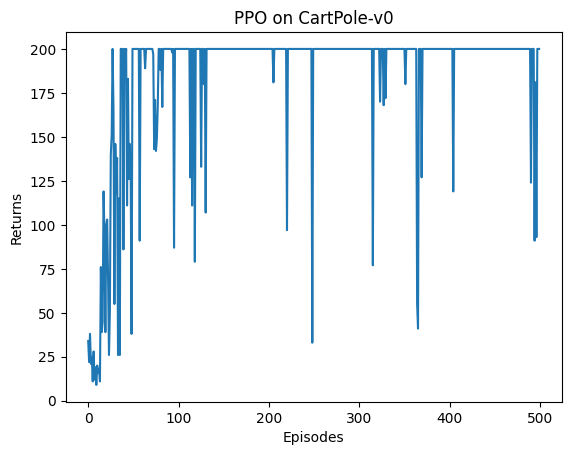

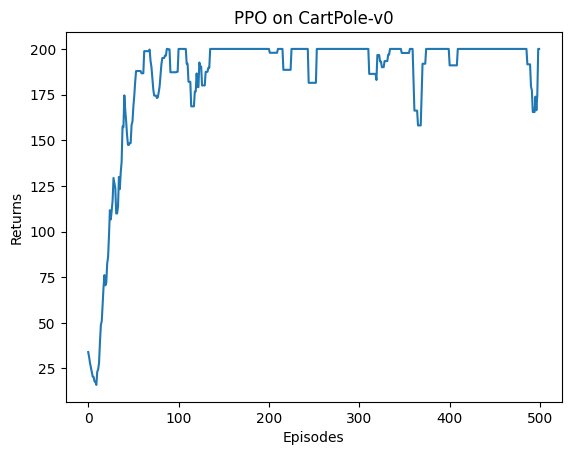

In [ ]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

In [ ]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std


class PPOContinuous:
    ''' 处理连续动作的PPO算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state)
        action_dist = torch.distributions.Normal(mu, sigma)
        action = action_dist.sample()
        return [action.item()]

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0  # 和TRPO一样,对奖励进行修改,方便训练
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        # 动作是正态分布
        old_log_probs = action_dists.log_prob(actions)

        for _ in range(self.epochs):
            mu, std = self.actor(states)
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [ ]:
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v0'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

# Iteration 0: 100%|██████████| 200/200 [02:15<00:00,  1.47it/s, episode=200,
# return=-984.137]
# Iteration 1: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=400,
# return=-895.332]
# Iteration 2: 100%|██████████| 200/200 [02:14<00:00,  1.48it/s, episode=600,
# return=-518.916]
# Iteration 3: 100%|██████████| 200/200 [02:19<00:00,  1.44it/s, episode=800,
# return=-602.183]
# Iteration 4: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1000,
# return=-392.104]
# Iteration 5: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1200,
# return=-259.206]
# Iteration 6: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1400,
# return=-221.772]
# Iteration 7: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1600,
# return=-293.515]
# Iteration 8: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1800,
# return=-371.194]
# Iteration 9: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=2000,
# return=-248.958]

/usr/local/miniconda3/envs/HandsonRL/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Pendulum-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


DeprecatedEnv: Environment version v0 for `Pendulum` is deprecated. Please use `Pendulum-v1` instead.

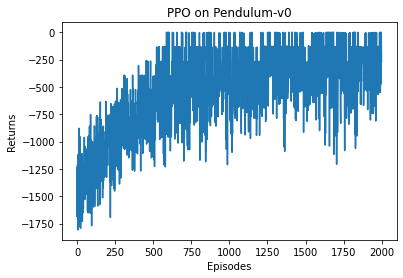

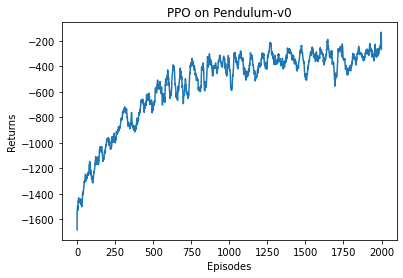

In [ ]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 21)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()